In [47]:
from tensorflow.python.keras.layers import  Activation, Dense, Dropout, LSTM
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error


## PREPROCESSING

In [48]:
SPX = pd.read_fwf('data/SPX.txt' ,names=['Date', 'Close'], parse_dates=True)

In [49]:
SPX.head()

,Date,Close
0,06/01/1995,"460,68"
1,13/01/1995,"465,97"
2,20/01/1995,"464,78"
3,27/01/1995,"470,39"
4,03/02/1995,"478,64"


In [50]:
#SPX.Date = pd.to_datetime(SPX.Date, infer_datetime_format=True)

In [51]:
VIX = pd.read_fwf('data/VIX.txt' ,names=['Date', 'Close'], parse_dates=True)

In [52]:
VIX.head()

,Date,Close
0,06/01/1995,"13,13"
1,13/01/1995,"11,1"
2,20/01/1995,"12,15"
3,27/01/1995,"11,25"
4,03/02/1995,"10,98"


In [53]:
SPX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1292 entries, 0 to 1291
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    1292 non-null   object
 1   Close   1292 non-null   object
dtypes: object(2)
memory usage: 20.3+ KB


In [54]:
SPX.describe()

,Date,Close
count,1292,1292
unique,1292,1243
top,24/10/2014,"1282,8"
freq,1,3


In [55]:
SPX['Close'] = SPX['Close'].apply(lambda x: float(x.split()[0].replace(',', '.')))
VIX['Close'] = VIX['Close'].apply(lambda x: float(x.split()[0].replace(',', '.')))

In [56]:
print(SPX.index)
print(VIX.index)

RangeIndex(start=0, stop=1292, step=1)
RangeIndex(start=0, stop=1292, step=1)


In [57]:
SPX.head()

,Date,Close
0,06/01/1995,460.68
1,13/01/1995,465.97
2,20/01/1995,464.78
3,27/01/1995,470.39
4,03/02/1995,478.64


In [58]:
SPX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1292 entries, 0 to 1291
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1292 non-null   object 
 1   Close   1292 non-null   float64
dtypes: float64(1), object(1)
memory usage: 20.3+ KB


## **EVOLUTION DES NOS DONNEES**

In [59]:
def Plotting_evolution(data):
    data['Close'].plot(figsize=(18, 6))
    plt.show()

EVOLUTION DE SPX_Data DANS LE TEMPS


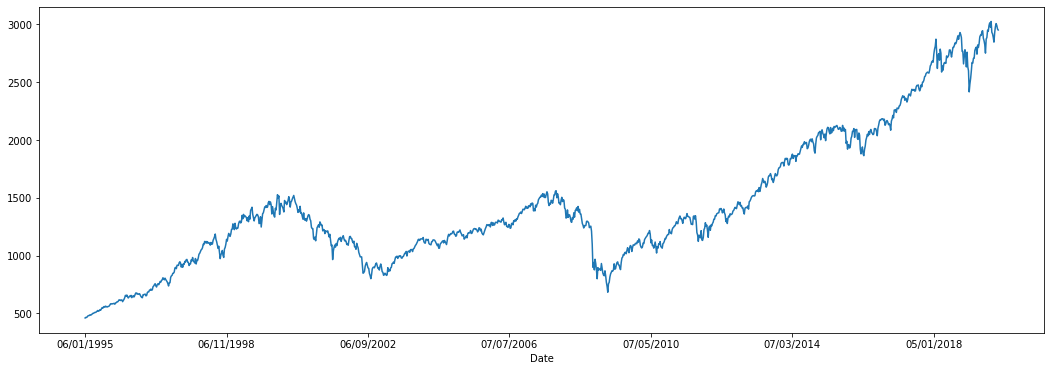

EVOLUTION DE VIX_Data DANS LE TEMPS


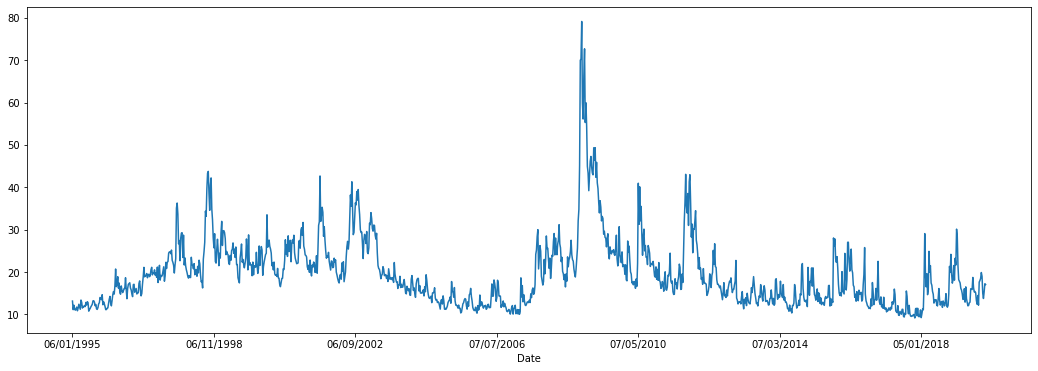

In [60]:
SPX_ = SPX.set_index('Date')
VIX_ = VIX.set_index('Date')
data = [SPX_, VIX_]
Names =  ['SPX_Data', 'VIX_Data']

for i in range(len(data)):
    print('EVOLUTION DE {} DANS LE TEMPS'.format(Names[i]))
    Plotting_evolution(data[i])

In [61]:
SPX_data = SPX.copy()
SPX_data['Date'] = pd.to_datetime(SPX_data['Date'])
SPX_data = SPX_data.set_index('Date')
SPX_data.head()

,Close
Date,
1995-06-01,460.68
1995-01-13,465.97
1995-01-20,464.78
1995-01-27,470.39
1995-03-02,478.64


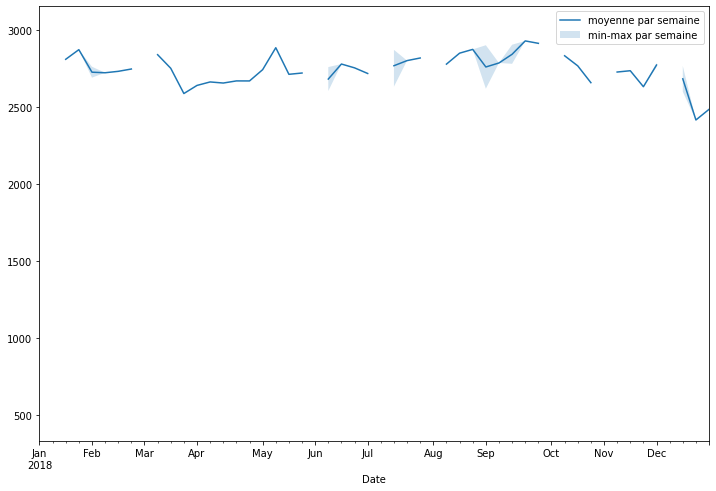

In [62]:
m = SPX_data['Close'].resample('W').agg(['mean', 'std', 'min', 'max'])

plt.figure(figsize=(12, 8))
m['mean']['2018'].plot(label='moyenne par semaine')
plt.fill_between(m.index, m['max'], m['min'], alpha=0.2, label='min-max par semaine')

plt.legend()
plt.show()

array([<AxesSubplot:xlabel='Date'>], dtype=object)

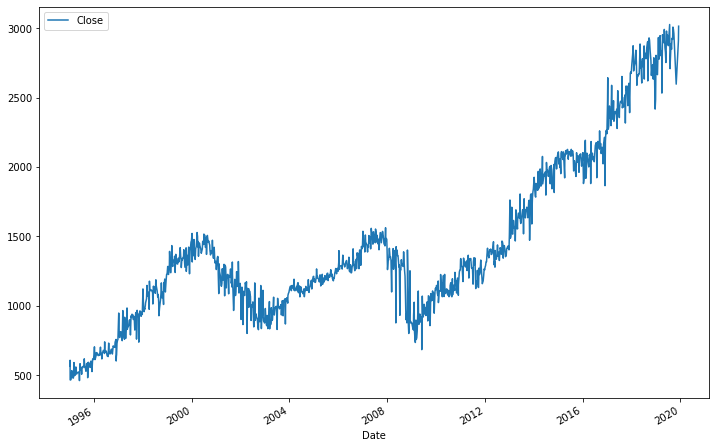

In [63]:
SPX_data[['Close']].plot(subplots=True, figsize=(12, 8))

## SPLIT DATA

In [64]:
train_SPX = SPX.loc[0:1110,'Close']
test_SPX = SPX.loc[1110:,'Close']

def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(14, 9))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('SPX/USDT', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

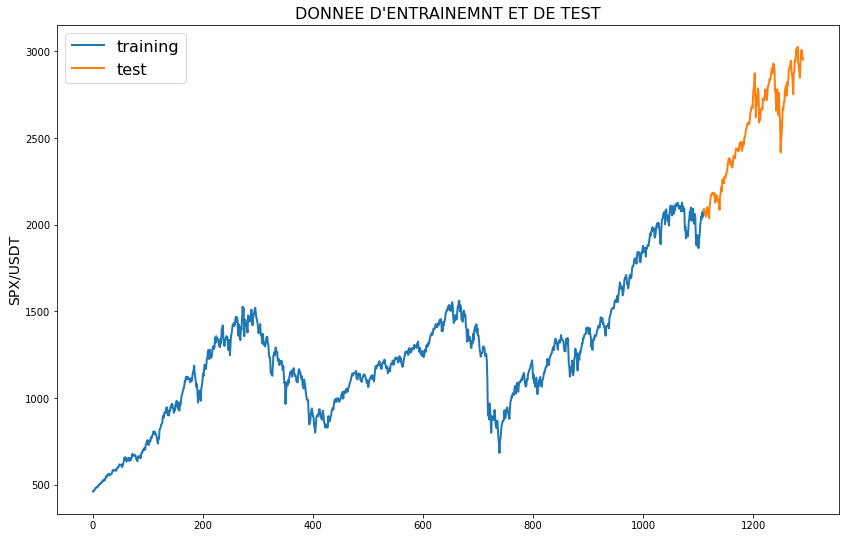

In [65]:
line_plot(train_SPX, test_SPX, 'training', 'test', title="DONNEE D'ENTRAINEMNT ET DE TEST")

---

## ON VEUT PREDIRE LE COURS DES 7 PROCHAIN JOURS

## TRAINING DATA

<AxesSubplot:>

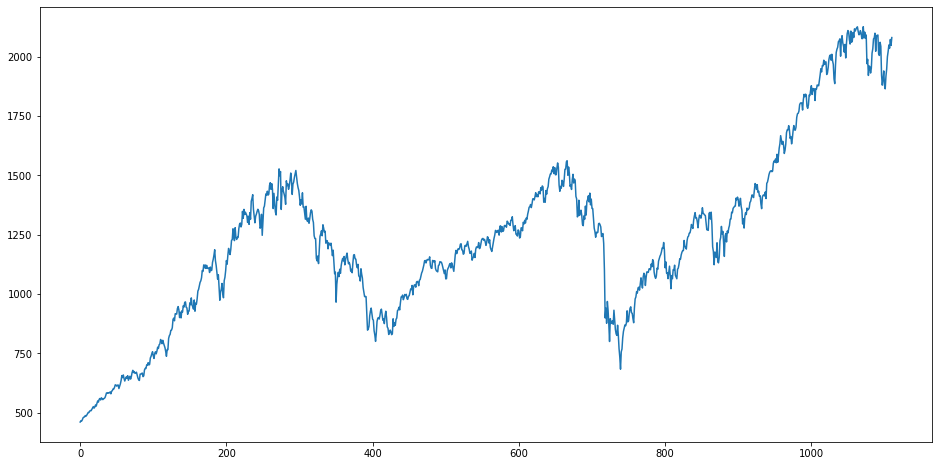

In [66]:
train_SPX.plot(figsize=(16,8))

## TEST DATA

<AxesSubplot:>

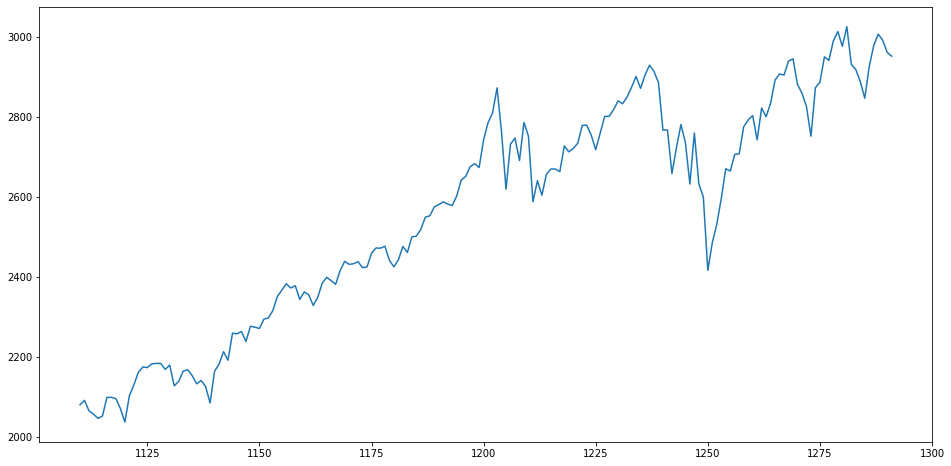

In [67]:
test_SPX.plot(figsize=(16,8))

# NORMALISATION DE DONNEES


In [68]:
def normalise_zero_base(data):
    return data / data.iloc[0] - 1

def normalise_min_max(data):
    return (data - data.min()) / (data.max() - data.min())

In [69]:
def extract_window_data(data, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(data) - window_len):
        tmp = data[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [70]:
def prepare_data(train_SPX, test_SPX,window_len=10, zero_base=True, test_size=0.2):
    X_train = extract_window_data(train_SPX, window_len, zero_base)
    X_test = extract_window_data(test_SPX, window_len, zero_base)
    y_train = train_SPX[window_len:].values
    y_test = test_SPX[window_len:].values
    if zero_base:
        y_train = y_train / train_SPX[:-window_len].values - 1
        y_test = y_test / test_SPX[:-window_len].values - 1
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return train_SPX, test_SPX, X_train, X_test, y_train, y_test

# MODELISATION 1 LSTM

- Creation de modele lstm

In [71]:
def build_lstm_model(input_data, output_size, neurons, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

- Les paramettres pour l'entrainement du model

In [72]:
np.random.seed(245)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 50
epochs = 40
batch_size = 32
loss = 'mse'
dropout = 0.24
optimizer = 'adam'

## SPLIT DATA

In [73]:
train_data, test_data, X_train, X_test, y_train, y_test = prepare_data(
train_SPX, test_SPX, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [74]:
print('Len of X training data', X_train.shape)
print('Len of Y training data',y_train.shape)
print('------------------------------')
print('Len of X test data',X_test.shape)
print('Len of y test data',y_test.shape)

Len of X training data (1106, 5, 1)
Len of Y training data (1106,)
------------------------------
Len of X test data (177, 5, 1)
Len of y test data (177,)


## TRAINING MODELE 1 LSTM

In [75]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
modelfit = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)
     

Epoch 1/40
35/35 [==============================] - 6s 21ms/step - loss: 0.0019 - val_loss: 7.5313e-04
Epoch 2/40
35/35 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 5.1502e-04
Epoch 3/40
35/35 [==============================] - 0s 9ms/step - loss: 0.0010 - val_loss: 5.0184e-04
Epoch 4/40
35/35 [==============================] - 0s 10ms/step - loss: 9.6846e-04 - val_loss: 4.5167e-04
Epoch 5/40
35/35 [==============================] - 0s 8ms/step - loss: 9.0345e-04 - val_loss: 4.1703e-04
Epoch 6/40
35/35 [==============================] - 0s 9ms/step - loss: 8.3317e-04 - val_loss: 3.9313e-04
Epoch 7/40
35/35 [==============================] - 0s 9ms/step - loss: 7.9419e-04 - val_loss: 3.8431e-04
Epoch 8/40
35/35 [==============================] - 0s 9ms/step - loss: 7.2833e-04 - val_loss: 3.5798e-04
Epoch 9/40
35/35 [==============================] - 0s 8ms/step - loss: 7.0984e-04 - val_loss: 3.3651e-04
Epoch 10/40
35/35 [==============================] - 0s 

## COURBE D'ENTRAINEMENT ET DE TEST

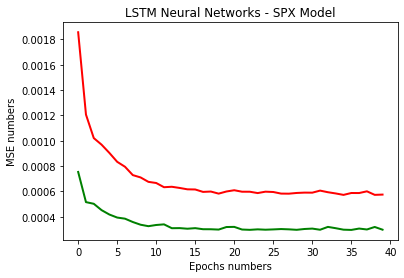

In [76]:
plt.plot(modelfit.history['loss'],'r',linewidth=2, label='Training loss')
plt.plot(modelfit.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM Neural Networks - SPX Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')
plt.show()

In [77]:
targets = test_SPX[window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.012519021494704173

In [78]:
from sklearn.metrics import mean_squared_error
SCORE_MSE=mean_squared_error(preds, y_test)
SCORE_MSE

0.000297394854279936

In [79]:
from sklearn.metrics import r2_score
r2_score1=r2_score(y_test, preds)
r2_score1*100

74.21780468990437

In [80]:
preds = test_SPX.values[:-window_len] * (preds + 1)
preds

array([2048.93317881, 2055.00798979, 2097.63038602, 2103.20115463,
       2096.54947407, 2072.03886684, 2041.25440967, 2098.41123582,
       2134.24198151, 2162.46495609, 2172.94771433, 2173.74765272,
       2181.51027709, 2185.26051297, 2185.49825549, 2171.4481935 ,
       2180.08874152, 2134.96848392, 2138.60176638, 2165.25753093,
       2173.60140836, 2155.53777406, 2134.20475365, 2141.51867076,
       2131.25552112, 2091.06506909, 2157.46928813, 2187.24517107,
       2213.85593033, 2191.98420305, 2252.93194118, 2261.44566307,
       2264.69269994, 2238.95972359, 2274.40601659, 2278.43277287,
       2273.92180227, 2292.09041362, 2300.17546225, 2316.12037203,
       2349.35443915, 2368.70900459, 2382.5077353 , 2373.61176238,
       2377.85149355, 2348.31217589, 2362.2032221 , 2359.33570055,
       2334.56795585, 2346.78244157, 2384.92686654, 2402.43221027,
       2392.18690735, 2381.56564901, 2413.72635303, 2441.07227221,
       2434.98907057, 2432.05931   , 2438.64792955, 2427.30539

In [81]:
preds = pd.Series(index=targets.index, data=preds)
preds

1115    2048.933179
1116    2055.007990
1117    2097.630386
1118    2103.201155
1119    2096.549474
           ...     
1287    2921.876980
1288    2982.595792
1289    3010.246424
1290    2991.384018
1291    2962.218242
Length: 177, dtype: float64

# PREDICTION DU MODEL 1 LSTM

<AxesSubplot:>

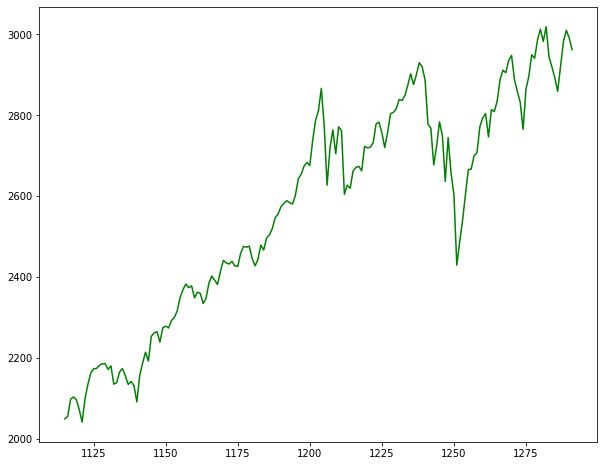

In [82]:
preds = pd.Series(index=targets.index, data=preds)
preds.plot(figsize=(10,8) , c='g')

## VRAIE DONNE DU TEST

<AxesSubplot:>

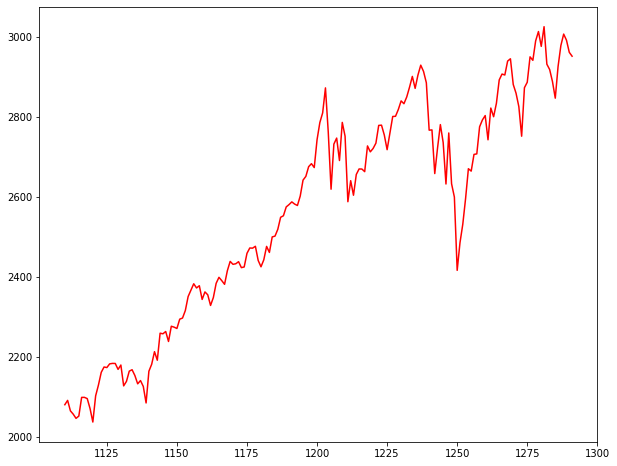

In [83]:
test_SPX.plot(figsize=(10,8), c='r')

## COMPARAISON DES VRAIE DONNEE AVEC LES PREDICTIONS

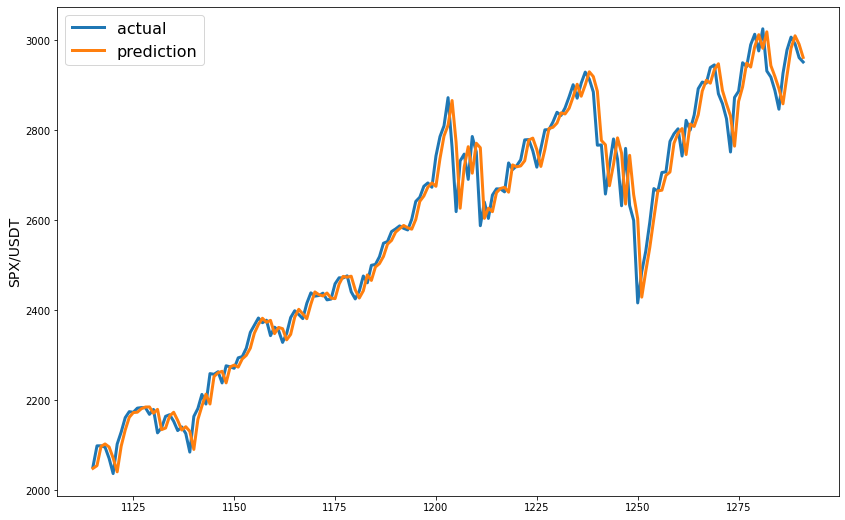

In [84]:
line_plot(targets, preds, 'actual', 'prediction', lw=3)

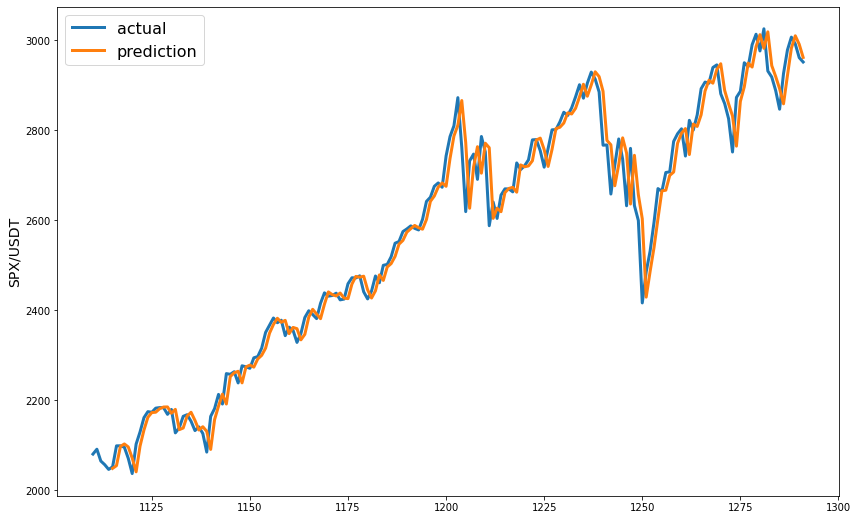

In [85]:
line_plot(test_SPX, preds, 'actual', 'prediction', lw=3)

## PREDICTION DU MODEL SUR LES DONNEES DE TEST

In [90]:
def line_plot(line1, line2,line3 ,label1=None, label2=None, label3=None,title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(14, 9))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw, c='r')
    ax.plot(line3, label=label3, linewidth=lw, c='g')
    ax.set_ylabel('SPX/USDT', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

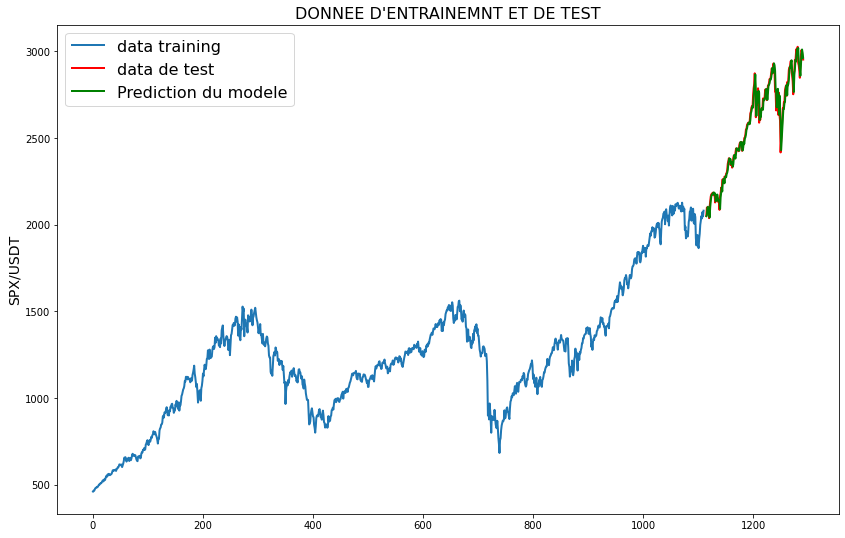

In [91]:
line_plot(train_SPX, targets,preds, 'data training','data de test', 'Prediction du modele', title="DONNEE D'ENTRAINEMNT ET DE TEST")

---

## MODEL 2 Recurrent Neural network AVEC KERAS

In [98]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM, GRU
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from pandas import Series
from tensorflow.python import keras
from tensorflow.python.keras import optimizers


In [99]:
df = SPX.set_index('Date')
data=df.copy()

In [100]:
data.head()

,Close
Date,
06/01/1995,460.68
13/01/1995,465.97
20/01/1995,464.78
27/01/1995,470.39
03/02/1995,478.64


In [101]:
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        #takes 
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i+look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [102]:
look_back=7
numpy.random.seed(0)

# load the dataset
dataframe = data
dataset = dataframe.values
dataset = dataset.astype('float64').reshape(-1, 1)
# normalize the dataset
scaler = MinMaxScaler()
#scaler=RobustScaler()
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
#look_back = 7
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network


## CREATE MODEL

In [103]:
model = Sequential()

model.add(LSTM(256, return_sequences=True,input_shape=(1, look_back)))
model.add(LSTM(256, return_sequences=True,input_shape=(1, look_back)))
#model.add(LSTM(256, return_sequences=True,input_shape=(1, look_back)))
model.add(LSTM(256))
model.add(Dense(1))

## COMPILE MODEL

In [104]:
#keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False, clipnorm=1)

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, verbose=1,shuffle=False,batch_size=50)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
predictions = numpy.empty_like(dataset)
predictions[:, :] = numpy.nan
predictions[look_back:len(trainPredict)+look_back, :] = trainPredict
predictions[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
#data=pd.DataFrame(numpy.concatenate((trainPredict[0:len(trainPredict)-look_back-1],testPredict[0:len(testPredict)-look_back-1])),columns=["predicted"])
#print('one',data.count())
#print('two',dataframe.count())
predictionsDF=pd.DataFrame(predictions,columns=["predicted"],index=dataframe.index)
ans=pd.concat([dataframe,predictionsDF],axis=1)
print( ans,[look_back,trainScore,testScore])

Epoch 1/50
18/18 [==============================] - 12s 31ms/step - loss: 0.0289
Epoch 2/50
18/18 [==============================] - 1s 33ms/step - loss: 0.0084
Epoch 3/50
18/18 [==============================] - 1s 32ms/step - loss: 0.0031
Epoch 4/50
18/18 [==============================] - 1s 35ms/step - loss: 0.0023
Epoch 5/50
18/18 [==============================] - 1s 42ms/step - loss: 0.0012
Epoch 6/50
18/18 [==============================] - 1s 46ms/step - loss: 4.9727e-04
Epoch 7/50
18/18 [==============================] - 1s 50ms/step - loss: 3.1535e-04
Epoch 8/50
18/18 [==============================] - 1s 42ms/step - loss: 3.1176e-04
Epoch 9/50
18/18 [==============================] - 1s 36ms/step - loss: 3.0663e-04
Epoch 10/50
18/18 [==============================] - 1s 31ms/step - loss: 3.0025e-04
Epoch 11/50
18/18 [==============================] - 1s 31ms/step - loss: 2.9623e-04
Epoch 12/50
18/18 [==============================] - 1s 37ms/step - loss: 2.9342e-04
Epoch 13

# Comparaison des donnees de train et test

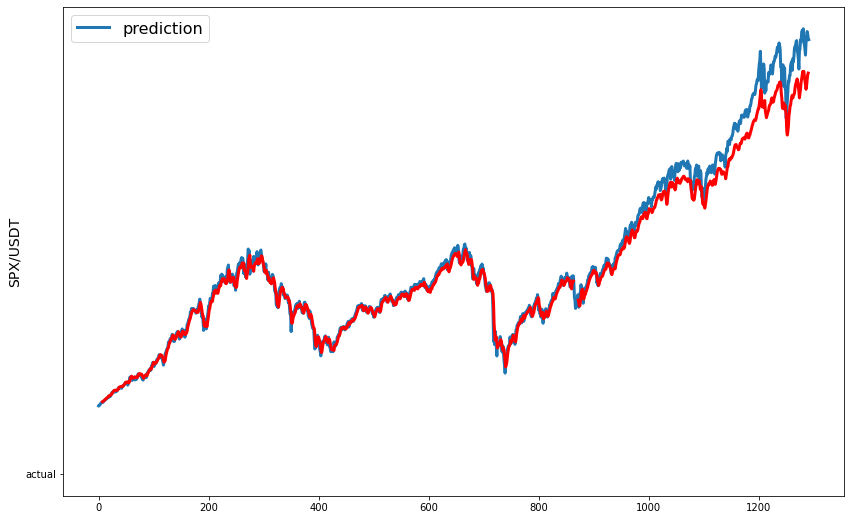

In [106]:
line_plot(SPX['Close'], predictions, 'actual', 'prediction', lw=3)

---

# MODELE 3 GRU

In [109]:
X = np.array(SPX['Close'])
X = X.reshape((1292, 1))

training_data_len = math.ceil(len(X)* 0.75)

sc = MinMaxScaler(feature_range=(0,1))
training_data = sc.fit_transform(X)
training_data

array([[0.        ],
       [0.00206228],
       [0.00159837],
       ...,
       [0.98682323],
       [0.97501092],
       [0.97122942]])

### SPLIT DATA

In [111]:
split_val = 887
train_data = training_data[0:split_val  , : ]

X_train = []
y_train = []
for i in range(180, len(train_data)):
    X_train.append(train_data[i-180:i, 0])
    y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print('Number of rows and columns: ', X_train.shape)

test_data = training_data[split_val - 180: , : ]

X_test = []
y_test =  X[split_val : , : ]
for i in range(180,len(test_data)):
    X_test.append(test_data[i-180:i,0])


X_test = np.array(X_test)


X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
print('Number of rows and columns: ', X_test.shape)


Number of rows and columns:  (707, 180, 1)
Number of rows and columns:  (405, 180, 1)


## CREATION DE MODELE

In [113]:
model_GRU = Sequential()

model_GRU.add(LSTM(units = 200, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model_GRU.add(Dropout(0.2))
model_GRU.add(GRU(units = 50, return_sequences = True))
model_GRU.add(Dropout(0.2))
model_GRU.add(GRU(units = 50, return_sequences = True))
model_GRU.add(Dropout(0.2))
model_GRU.add(GRU(units = 50, return_sequences=True))
model_GRU.add(Dropout(0.2))
model_GRU.add(GRU(units = 50, return_sequences=True))
model_GRU.add(Dropout(0.2))
model_GRU.add(GRU(units = 50, return_sequences=True))
model_GRU.add(Dropout(0.2))
model_GRU.add(GRU(units = 50))
model_GRU.add(Dropout(0.2))
model_GRU.add(Dense(units = 1))

### COMPILE MODEL

In [114]:
model_GRU.compile(
    optimizer = 'adam',
    loss = 'mean_squared_error')

### TRAINING MODEL

In [115]:
model_GRU.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
23/23 [==============================] - 89s 2s/step - loss: 0.0178
Epoch 2/50
23/23 [==============================] - 67s 3s/step - loss: 0.0049
Epoch 3/50
23/23 [==============================] - 54s 2s/step - loss: 0.0035
Epoch 4/50
23/23 [==============================] - 49s 2s/step - loss: 0.0026
Epoch 5/50
23/23 [==============================] - 61s 3s/step - loss: 0.0022
Epoch 6/50
23/23 [==============================] - 74s 3s/step - loss: 0.0016
Epoch 7/50
23/23 [==============================] - 67s 3s/step - loss: 0.0016
Epoch 8/50
23/23 [==============================] - 62s 3s/step - loss: 0.0015
Epoch 9/50
23/23 [==============================] - 71s 3s/step - loss: 0.0015
Epoch 10/50
23/23 [==============================] - 77s 3s/step - loss: 0.0013
Epoch 11/50
23/23 [==============================] - 66s 3s/step - loss: 0.0016
Epoch 12/50
23/23 [==============================] - 55s 2s/step - loss: 0.0014
Epoch 13/50
23/23 [==============================

### EVALUATION DE MODELE

In [116]:
pred2 = model_GRU.predict(X_test)
pred2 = sc.inverse_transform(pred2)
train = data[:split_val]
valid = data[split_val:]
valid['Predictions'] = pred2
score = r2_score(y_test, pred2)
score

<ipython-input-116-27eddc2dc2be>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = pred2


0.973889832893526

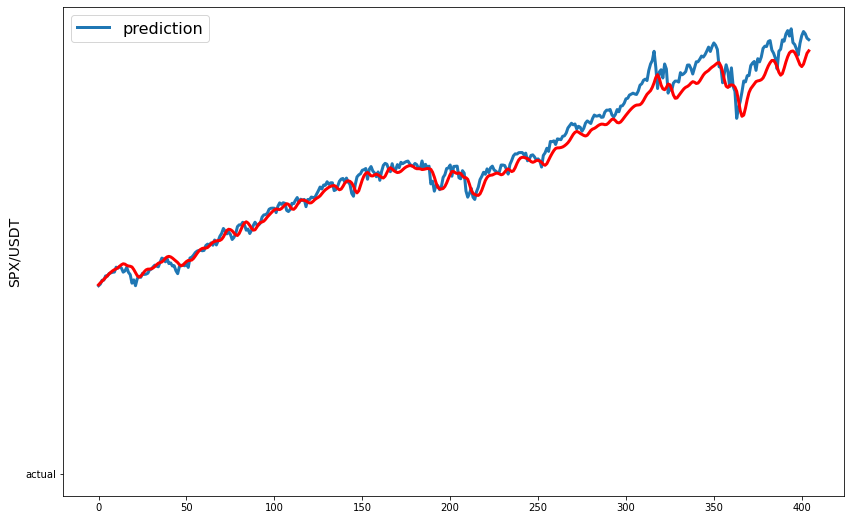

In [121]:
line_plot(y_test, pred2, 'actual', 'prediction', lw=3)